In [110]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize, Bounds

plt.rcParams.update({'font.size': 12})

In [ ]:
def W(params: np.array) -> float: # Potencial sfere v odvisnosti od koordinat nabojev

    num_electrons = len(params) // 2
    phi = params[:num_electrons]
    theta = params[num_electrons:]

    W = 0.0

    for i in range(num_electrons):

        for j in range(i + 1, num_electrons):
            dr = np.sqrt(2 - 2 * np.sin(theta[i]) * np.sin(theta[j]) * np.cos(phi[i] - phi[j]) - 2 * np.cos(theta[i]) * np.cos(theta[j]))
            W += 1 / dr

    return W


def gradW(params: np.array) -> np.array: # Gradient potenciala sfere

    gradW = np.zeros_like(params)

    num_electrons = len(params) // 2
    phi = params[:num_electrons]
    theta = params[num_electrons:]

    for i in range(num_electrons):
        gradphi_i = 0.
        gradtheta_i = 0.

        for j in range(num_electrons):

            if j == i:
                continue
            
            aphi = np.sin(theta[i]) * np.sin(theta[j]) * np.sin(phi[i]-phi[j])
            atheta = np.sin(theta[j]) * np.cos(theta[i]) * np.cos(phi[i]-phi[j]) - np.cos(theta[j]) * np.sin(theta[i])

            b = (2 - 2 * np.sin(theta[i]) * np.sin(theta[j]) * np.cos(phi[i]-phi[j]) - 2 * np.cos(theta[i]) * np.cos(theta[j]))**(3/2)
            
            gradphi_i += - aphi/b
            gradtheta_i += atheta/b
        
        gradW[i] = gradphi_i
        gradW[i+num_electrons] = gradtheta_i
    
    return gradW


def W_kond(params: np.array) -> float: # Potencial sfere v koondenzatorju v odvisnosti od koordinat nabojev

    num_electrons = len(params) // 2
    phi = params[:num_electrons]
    theta = params[num_electrons:]

    E = 10.
    W_kond = 0.0

    for i in range(num_electrons):

        for j in range(i + 1, num_electrons):
            dr = np.sqrt(2 - 2 * np.sin(theta[i]) * np.sin(theta[j]) * np.cos(phi[i] - phi[j]) - 2 * np.cos(theta[i]) * np.cos(theta[j]))
            W_kond += 1 / dr
        
        W_kond += - E * np.cos(theta[i])

    return W_kond


def gradW_kond(params: np.array) -> np.array: # Gradient potenciala sfere v kondenzatorju

    E = 10.
    gradW_kond = np.zeros_like(params)

    num_electrons = len(params) // 2
    phi = params[:num_electrons]
    theta = params[num_electrons:]

    for i in range(num_electrons):
        gradphi_i = 0.
        gradtheta_i = 0.

        for j in range(num_electrons):

            if j == i:
                continue
            
            aphi = np.sin(theta[i]) * np.sin(theta[j]) * np.sin(phi[i]-phi[j])
            atheta = np.sin(theta[j]) * np.cos(theta[i]) * np.cos(phi[i]-phi[j]) - np.cos(theta[j]) * np.sin(theta[i])

            b = (2 - 2 * np.sin(theta[i]) * np.sin(theta[j]) * np.cos(phi[i]-phi[j]) - 2 * np.cos(theta[i]) * np.cos(theta[j]))**(3/2)
            
            gradphi_i += - aphi/b
            gradtheta_i += atheta/b
        
        gradtheta_i += E * np.sin(theta[i])
        
        gradW_kond[i] = gradphi_i
        gradW_kond[i+num_electrons] = gradtheta_i
    
    return gradW_kond


def W_krog(params: np.array) -> float: # Potencial na krogu (2D) v odvisnosti od koordinat nabojev
    num_electrons = len(params) // 2
    r = params[:num_electrons]
    phi = params[num_electrons:]

    W_krog = 0.0

    for i in range(num_electrons):

        for j in range(i + 1, num_electrons):
            dr = np.sqrt(r[i]**2 + r[j]**2 - 2 * r[i] * r[j] * np.cos(phi[i]-phi[j]))
            W_krog += 1 / dr

    return W_krog


def W_torus(params: np.array) -> float: # Potencial na torusu (3D) v odvisnosti od koordinat nabojev
    num_electrons = len(params) // 2
    phi = params[:num_electrons]
    theta = params[num_electrons:]

    r = 0.25
    W_torus = 0.0

    for i in range(num_electrons):
        xi = (1 + r * np.cos(theta[i])) * np.cos(phi[i])
        yi = (1 + r * np.cos(theta[i])) * np.sin(phi[i])
        zi = r * np.sin(theta[i])

        for j in range(i + 1, num_electrons):
            xj = (1 + r * np.cos(theta[j])) * np.cos(phi[j])
            yj = (1 + r * np.cos(theta[j])) * np.sin(phi[j])
            zj = r * np.sin(theta[j])

            # Calculate the Euclidean distance between points (xi, yi, zi) and (xj, yj, zj)
            dr = np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2 + (zi - zj) ** 2)
            W_torus += 1 / dr

    return W_torus


def W_elipsoid(params: np.array) -> float: # Potencial na torusu (3D) v odvisnosti od koordinat nabojev
    num_electrons = len(params) // 2
    phi = params[:num_electrons]
    theta = params[num_electrons:]

    a = 1
    b = 0.5
    c = 0.8
    W_elipsoid = 0.0

    for i in range(num_electrons):
        xi = a * np.sin(theta[i]) * np.cos(phi[i])
        yi = b * np.sin(theta[i]) * np.sin(phi[i])
        zi = c * np.cos(theta[i])

        for j in range(i + 1, num_electrons):
            xj = a * np.sin(theta[j]) * np.cos(phi[j])
            yj = b * np.sin(theta[j]) * np.sin(phi[j])
            zj = c * np.cos(theta[j])

            # Calculate the Euclidean distance between points (xi, yi, zi) and (xj, yj, zj)
            dr = np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2 + (zi - zj) ** 2)
            W_elipsoid += 1 / dr
    
    return W_elipsoid

In [ ]:
tabela = pd.read_csv('tabela.txt', sep='\t', header=0)
energije = tabela['energ'].values
Ns = tabela['st'].values

print(len(Ns))
print(len(energije))

## Prikaz energije v odvisnosti od N delcev na sferi

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(111)
ax.grid()
ax.set_title('Potencialna energija v odvisnosti od števila delcev')
ax.set_ylabel(r'$W$')
ax.set_xlabel(r'$N$')
ax.scatter(Ns, energije)

plt.show()

## Časovna zahtevnost, natančnost in niter metod

In [ ]:
Ns = np.arange(2, 10, 1)

# Shranjujem info
info = {
    'Nelder-Mead' : np.zeros((3, len(Ns))),
    'Powell' : np.zeros((3, len(Ns))),
    'CG' : np.zeros((6, len(Ns))),
    'BFGS' : np.zeros((6, len(Ns))),
    'L-BFGS-B' : np.zeros((6, len(Ns))),
    'SLSQP' : np.zeros((6, len(Ns)))
}

for i, N in enumerate(Ns):
    initial_guess = np.random.rand(2*N)

    for method in info.keys():
        
        # Čas metode
        t1 = time.time()
        result = minimize(W, initial_guess, method=method)
        t2 = time.time()
        info[f'{method}'][0][i] = t2-t1

        # Natančnost metode
        rel = np.abs(result.fun/energije[i] - 1)
        info[f'{method}'][1][i] = rel
        
        # Koraki metode
        info[f'{method}'][2][i] = result.nit
        
        if method not in ['Nelder-Mead', 'Powell']:
            # Čas metode z gradientom
            t1 = time.time()
            result = minimize(W, initial_guess, method=method, jac=gradW)
            t2 = time.time()
            info[f'{method}'][3][i] = t2-t1

            # Natančnost metode
            rel = np.abs(result.fun/energije[i] - 1)
            info[f'{method}'][4][i] = rel

            # Koraki metode
            info[f'{method}'][5][i] = result.nit

In [ ]:
fig = plt.figure(figsize=(10,16))

ax1 = fig.add_subplot(3,1,1)
ax1.set_yscale('log')
ax1.grid()
ax1.set_title('Časovna zahtevnost')
ax1.set_ylabel(r'$t\,$[s]')
ax1.set_xlabel(r'$N$')

ax2 = fig.add_subplot(3,1,2)
ax2.set_yscale('log')
ax2.grid()
ax2.set_title('Relativna napaka')
ax2.set_ylabel(r'$\Delta E / E$')
ax2.set_xlabel(r'$N$')

ax3 = fig.add_subplot(3,1,3)
ax3.set_yscale('log')
ax3.grid()
ax3.set_title('Število iteracij')
ax3.set_ylabel(r'$N_{it}$')
ax3.set_xlabel(r'$N$')

for method in info.keys():
    ax1.scatter(Ns, info[f'{method}'][0], label=f'{method}')
    ax2.scatter(Ns, info[f'{method}'][1], label=f'{method}')
    ax3.scatter(Ns, info[f'{method}'][2], label=f'{method}')

ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,16))

ax1 = fig.add_subplot(3,1,1)
ax1.set_yscale('log')
ax1.grid()
ax1.set_title('Časovna zahtevnost')
ax1.set_ylabel(r'$t\,$[s]')
ax1.set_xlabel(r'$N$')

ax2 = fig.add_subplot(3,1,2)
ax2.set_yscale('log')
ax2.grid()
ax2.set_title('Relativna napaka')
ax2.set_ylabel(r'$\Delta E / E$')
ax2.set_xlabel(r'$N$')

ax3 = fig.add_subplot(3,1,3)
ax3.set_yscale('log')
ax3.grid()
ax3.set_title('Število iteracij')
ax3.set_ylabel(r'$N_{it}$')
ax3.set_xlabel(r'$N$')

for method in ['CG', 'BFGS', 'L-BFGS-B', 'SLSQP']:
    ax1.scatter(Ns, info[f'{method}'][0], label=f'{method}')
    ax1.scatter(Ns, info[f'{method}'][3], label=f'{method} + jac')
    ax2.scatter(Ns, info[f'{method}'][1], label=f'{method}')
    ax2.scatter(Ns, info[f'{method}'][4], label=f'{method} + jac')
    ax3.scatter(Ns, info[f'{method}'][2], label=f'{method}')
    ax3.scatter(Ns, info[f'{method}'][5], label=f'{method} + jac')

ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

## Grafični prikaz nekaj primerov rešitev na sferi

In [ ]:
Ns = [2, 3, 4, 5, 6, 8, 10, 15, 20]

coord = {f'{N}': np.zeros((3,N)) for N in Ns}

for N in Ns:
    initial_guess = np.random.rand(2*N)  # Initial guess for phi and theta
    result = minimize(W, initial_guess, method='BFGS')
    optimized_params = result.x

    # Extract the optimized phi and theta values
    optimized_phi = optimized_params[:N]
    optimized_theta = optimized_params[N:]

    # Calculate the (x, y, z) coordinates on a unit sphere
    x = np.sin(optimized_theta) * np.cos(optimized_phi)
    y = np.sin(optimized_theta) * np.sin(optimized_phi)
    z = np.cos(optimized_theta)

    coord[f'{N}'][0] = x 
    coord[f'{N}'][1] = y 
    coord[f'{N}'][2] = z 

In [ ]:
# Create a meshgrid for the unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones_like(u), np.cos(v))

# Create a 3D scatter plot
fig = plt.figure(figsize=(10,10))

for i, key in enumerate(coord.keys()):
    x = coord[key][0]
    y = coord[key][1]
    z = coord[key][2]

    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.set_title('N = ' + key)
    ax.grid(False)
    ax.plot_surface(x_sphere, y_sphere, z_sphere, color='darkgray', alpha=0.2)
    ax.scatter(x, y, z, c='darkred', marker='o', s=50)

plt.show()

## Energije in prikaz porazdelitve na različlnih telesih

In [ ]:
method = 'L-BFGS-B'

Ns = np.arange(2, 10, 1)

# Shranjujem info
energies = {
    'kondenzator' : np.zeros(len(Ns)),
    'krog' : np.zeros(len(Ns)),
    'torus' : np.zeros( len(Ns)),
    'elipsoid' : np.zeros( len(Ns))
}

for i, N in enumerate(Ns):
    initial_guess = np.random.rand(2*N)

    best_value = float('inf')  # Initialize to positive infinity
    num_iterations = 10
    for _ in range(num_iterations):
        initial_guess_kond = np.append(np.random.rand(N)*2*np.pi, np.random.rand(N)*np.pi)
        result = minimize(W_kond, initial_guess_kond, method='BFGS')
        if result.fun < best_value:
            best_value = result.fun
    energies['kondenzator'][i] = best_value

    bounds_list = [(0, 1) if i < N else (-np.inf, np.inf) for i in range(2*N)]
    bounds = Bounds(*zip(*bounds_list))
    result = minimize(W_krog, initial_guess, method=method, bounds=bounds)
    energies['krog'][i] = result.fun

    result = minimize(W_torus, initial_guess, method=method)
    energies['torus'][i] = result.fun

    result = minimize(W_elipsoid, initial_guess, method=method)
    energies['elipsoid'][i] = result.fun

In [ ]:
fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(111)
ax.grid()
ax.set_title('Potencialna energija v odvisnosti od števila delcev')
ax.set_ylabel(r'$W$')
ax.set_xlabel(r'$N$')

ax.plot(Ns, energije[:len(Ns)], marker='o', label='sfera')

for key in energies.keys():
    ax.plot(Ns, energies[key], marker='o', label=key)

ax.legend()
plt.show()

- Sfera v kondenzatorju

In [ ]:
Ns = [2, 3, 4, 5, 6, 8, 10, 15, 20]

coord = {f'{N}': np.zeros((3,N)) for N in Ns}

for N in Ns:
    
    best_value = float('inf')  # Initialize to positive infinity
    optimized_params = None
    num_iterations = 30
    for _ in range(num_iterations):
        initial_guess = np.append(np.random.rand(N)*2*np.pi, np.random.rand(N)*np.pi)
        result = minimize(W_kond, initial_guess, method='BFGS')

        if result.fun < best_value:
            best_value = result.fun
            optimized_params = result.x

    # Extract the optimized phi and theta values
    optimized_phi = optimized_params[:N]
    optimized_theta = optimized_params[N:]

    # Calculate the (x, y, z) coordinates on a unit sphere
    x = np.sin(optimized_theta) * np.cos(optimized_phi)
    y = np.sin(optimized_theta) * np.sin(optimized_phi)
    z = np.cos(optimized_theta)

    coord[f'{N}'][0] = x 
    coord[f'{N}'][1] = y 
    coord[f'{N}'][2] = z 

In [ ]:
# Create a meshgrid for the unit sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x_sphere = np.outer(np.cos(u), np.sin(v))
y_sphere = np.outer(np.sin(u), np.sin(v))
z_sphere = np.outer(np.ones_like(u), np.cos(v))

# Create a 3D scatter plot
fig = plt.figure(figsize=(10,10))

for i, key in enumerate(coord.keys()):
    x = coord[key][0]
    y = coord[key][1]
    z = coord[key][2]

    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.set_title('N = ' + key)
    ax.grid(False)
    ax.plot_surface(x_sphere, y_sphere, z_sphere, color='darkgray', alpha=0.3)
    ax.scatter(x, y, z, c='darkred', marker='o', s=50)
    ax.set_xlabel('X')

plt.show()

- krog

In [ ]:
Ns = [2, 3, 4, 5, 6, 8, 10, 15, 20]

coord = {f'{N}': np.zeros((2,N)) for N in Ns}

for N in Ns:
    best_value = float('inf')  # Initialize to positive infinity
    optimized_params = None
    num_iterations = 10

    for _ in range(num_iterations):
        initial_guess = np.append(np.random.rand(N), np.random.rand(N)*2*np.pi)
        bounds_list = [(0, 1) if i < N else (-np.inf, np.inf) for i in range(2*N)]
        bounds = Bounds(*zip(*bounds_list))
        result = minimize(W_krog, initial_guess, method=method, bounds=bounds)

        if result.fun < best_value:
            best_value = result.fun
            optimized_params = result.x

    # Extract the optimized phi and theta values
    optimized_r = optimized_params[:N]
    optimized_phi = optimized_params[N:]

    # Calculate the (x, y, z) coordinates on a circle
    x = optimized_r * np.cos(optimized_phi)
    y = optimized_r * np.sin(optimized_phi)

    coord[f'{N}'][0] = x 
    coord[f'{N}'][1] = y

In [ ]:
fig = plt.figure(figsize=(10,10))

for i, key in enumerate(coord.keys()):
    x = coord[key][0]
    y = coord[key][1]

    ax = fig.add_subplot(3, 3, i+1)
    ax.set_title('N = ' + key)
    ax.grid(False)
    circle = plt.Circle((0, 0), 1, color='darkgray', alpha=0.3)
    ax.add_artist(circle)
    ax.scatter(x, y, c='darkred', marker='o', s=50)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)

    # Set equal aspect ratio for a perfect circle
    ax.set_aspect('equal', adjustable='box')

plt.show()


- Torus

In [ ]:
Ns = [2, 3, 4, 5, 6, 8, 10, 15, 20]
r = 0.25

coord = {f'{N}': np.zeros((3,N)) for N in Ns}

for N in Ns:
    
    best_value = float('inf')  # Initialize to positive infinity
    optimized_params = None
    num_iterations = 5
    for _ in range(num_iterations):
        initial_guess = np.append(np.random.rand(N), np.random.rand(N))
        result = minimize(W_torus, initial_guess, method='BFGS')

        if result.fun < best_value:
            best_value = result.fun
            optimized_params = result.x

    # Extract the optimized phi and theta values
    optimized_phi = optimized_params[:N]
    optimized_theta = optimized_params[N:]

    # Calculate the (x, y, z) coordinates on a torus
    x = (1 + r*np.cos(optimized_theta)) * np.cos(optimized_phi)
    y = (1 + r*np.cos(optimized_theta)) * np.sin(optimized_phi)
    z = r*np.sin(optimized_theta)

    coord[f'{N}'][0] = x 
    coord[f'{N}'][1] = y 
    coord[f'{N}'][2] = z 

In [ ]:
# Parameters
R = 1.0  # Major radius
r = 0.25  # Minor radius
u = np.linspace(0, 2 * np.pi, 100)  # Parametric variable for the torus
v = np.linspace(0, 2 * np.pi, 100)  # Parametric variable for the torus

# Create a meshgrid for the torus
u, v = np.meshgrid(u, v)
x_torus = (R + r * np.cos(v)) * np.cos(u)
y_torus = (R + r * np.cos(v)) * np.sin(u)
z_torus = r * np.sin(v)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10,10))

for i, key in enumerate(coord.keys()):
    x = coord[key][0]
    y = coord[key][1]
    z = coord[key][2]

    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.set_title('N = ' + key)
    ax.grid(False)
    ax.plot_surface(x_torus, y_torus, z_torus, color='darkgray', alpha=0.3)
    ax.scatter(x, y, z, c='darkred', marker='o', s=50)
    ax.set_zlim(-0.6, 0.6)

plt.show()

- Elipsoid

In [ ]:
Ns = [2, 3, 4, 5, 6, 8, 10, 15, 20]
b = 0.5
c = 0.8

coord = {f'{N}': np.zeros((3,N)) for N in Ns}

for N in Ns:
    
    best_value = float('inf')  # Initialize to positive infinity
    optimized_params = None
    num_iterations = 5
    for _ in range(num_iterations):
        initial_guess = np.append(np.random.rand(N), np.random.rand(N))
        result = minimize(W_elipsoid, initial_guess, method='BFGS')

        if result.fun < best_value:
            best_value = result.fun
            optimized_params = result.x

    # Extract the optimized phi and theta values
    optimized_phi = optimized_params[:N]
    optimized_theta = optimized_params[N:]

    # Calculate the (x, y, z) coordinates on a torus
    x = np.sin(optimized_theta) * np.cos(optimized_phi)
    y = b * np.sin(optimized_theta) * np.sin(optimized_phi)
    z = c * np.cos(optimized_theta)

    coord[f'{N}'][0] = x 
    coord[f'{N}'][1] = y 
    coord[f'{N}'][2] = z 

In [ ]:
# Parameters
a = 1.0
b = 0.5
c = 0.8

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

u, v = np.meshgrid(u, v)
x_elipsoid = a * np.cos(u) * np.sin(v)
y_elipsoid = b * np.sin(u) * np.sin(v)
z_elipsoid = c * np.cos(v)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10,10))

for i, key in enumerate(coord.keys()):
    x = coord[key][0]
    y = coord[key][1]
    z = coord[key][2]

    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.set_title('N = ' + key)
    ax.grid(False)
    ax.plot_surface(x_elipsoid, y_elipsoid, z_elipsoid, color='darkgray', alpha=0.3)
    ax.scatter(x, y, z, c='darkred', marker='o', s=50)
    ax.set_zlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)

plt.show()

--------
--------

## 2. DEL NALOGE - OPTIMALNA VOŽNJA

--------
--------

In [125]:
# Teoretično
nu0 = 4.

teo_taus = np.linspace(0, 1, 1000) 

def nu(tau, nu0):
    return nu0 + 3/2 * (1-nu0) * (2*tau - tau**2)

teo_nus = nu(teo_taus, nu0)

C:\Users\Tadej\AppData\Local\Temp\ipykernel_13960\2840647386.py:56: RuntimeWarning: overflow encountered in exp
  F2 += 1 + np.exp(-kappa2*nus[i])
C:\Users\Tadej\AppData\Local\Temp\ipykernel_13960\2840647386.py:44: RuntimeWarning: overflow encountered in exp
  res = 1 + np.exp(kappa1 * (a-N))


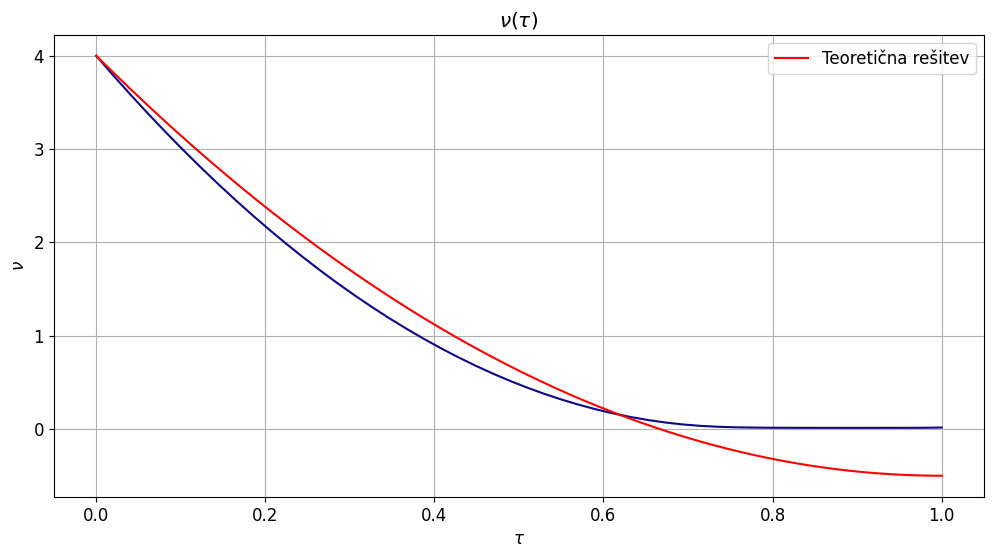

In [126]:
# Numerično

Ns = np.arange(50, 51, 1) # st tock
nu0 = 4.
kappa1 = 10
kappa2 = 100

cmap = get_cmap('plasma')
norm = Normalize(vmin=min(Ns), vmax=max(Ns))
plt.figure(figsize=(12,6))
plt.title(r'$\nu(\tau)$')
plt.ylabel(r'$\nu$')
plt.xlabel(r'$\tau$')
plt.grid()

for N in Ns:
    taus = np.linspace(0, 1, N)
    dtau = taus[1] - taus[0]

    def F0(nus):

        F0 = 0.
        F0 += 1/2 * (nus[0]/dtau)**2

        for i in range(1, len(taus)-1):
            F0 += ((nus[i]-nus[i-1])/dtau)**2

        F0 += 1/2 * ((nus[-1]-nus[-2])/dtau)**2

        return F0


    def F1(nus):

        a = 0
        a += 1/2 * nus[0]

        for i in range(1, len(nus)-1):
            a += nus[i]

        a += 1/2 * nus[-1]

        try:
            res = 1 + np.exp(kappa1 * (a-N))
        except:
            res = np.inf

        return res


    def F2(nus):

        F2 = 0

        for i in range(0, len(nus)):
            F2 += 1 + np.exp(-kappa2*nus[i])

        return F2


    def func1(nus):
        return F0(nus) + F1(nus) + F2(nus)


    niter = 10

    best_val = np.inf
    opt_nus = None
    bounds = [(nu0-0.001, nu0+0.001)] + [(-10., 10.) for _ in range(N-1)]
    bounds = Bounds(*zip(*bounds))
    for _ in range(niter):
        initial_guess = np.random.rand(N)
        result = minimize(func1, x0=initial_guess, method='SLSQP', bounds=bounds)

        if result.fun < best_val and result.success == True:
            best_val = result.fun
            opt_nus = result.x
    
    color = cmap(norm(N))
    plt.plot(taus, opt_nus, color=color)


plt.plot(teo_taus, teo_nus, label='Teoretična rešitev', color='red')

# Add a colorbar to show the mapping of nu0 values to colors
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])
#cbar = plt.colorbar(sm, label=r'$N$')
plt.legend()
plt.show()